In [1]:
import <- function(pkg) { library(pkg, warn.conflicts=F, quietly=T, character.only=T) }
import("repr")
import("stringr")
import("tidyr")
import("dplyr")
import("ggplot2")
import("lme4")
import("emmeans")


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [2]:
options(repr.matrix.max.cols=15, repr.matrix.max.rows=20)
my.theme <- theme(legend.text=element_text(size=5),
                  legend.title=element_text(size=5),
                  plot.title = element_text(size=6, hjust=0.5),
                  axis.line=element_line(linewidth=0.25),
                  axis.ticks=element_line(linewidth=0.25),
                  axis.ticks.length=unit(0.05, "cm"),
                  axis.title=element_text(size=6),
                  axis.text=element_text(size=5),
                  strip.placement="outside",
                  strip.text=element_text(size=6),
                  strip.background=element_blank())
no.legend <- theme(legend.position="none")
update_geom_defaults("point", list(fill="white", shape=21, size=0.6))
update_geom_defaults("line", list(linewidth=0.25))


## Loading data and first steps of analysis

### Metadata

In [3]:
birds <- (
    data.table::fread("../inputs/bird_metadata.csv")
    |> mutate(age_group = cut(age, c(0,20,35,121), labels = (c('J18','J30','Adult'))))
)
sites <- data.table::fread("../inputs/recording_metadata.csv")
all_sites <- (
   sites
   |> mutate(bird=str_match(site, "[:alnum:]+")[,1])
   |> inner_join(birds, by="bird")
   |> filter(area %in% c("deep", "intermediate", "superficial"), stim_amplitude == "okay")
   |> filter(area =='deep')
   |> mutate(area=forcats::fct_recode(area, "L3/NCM"="deep") |> forcats::fct_relevel(c("L3/NCM")),
             group=factor(group, levels=c("CR", "PR")))
)


In [4]:
all_sites

site,hemisphere,area,stim_amplitude,bird,uuid,sex,group,age,sibling,age_group
<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<fct>
C31_1_1,L,L3/NCM,okay,C31,6d0caa42,M,PR,108,2,Adult
C31_2_1,L,L3/NCM,okay,C31,6d0caa42,M,PR,108,2,Adult
C41_1_1,L,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C41_2_1,L,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C41_3_1,L,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C41_6_1,R,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C44_3_1,L,L3/NCM,okay,C44,471dcc13,M,PR,111,4,Adult
C44_6_1,R,L3/NCM,okay,C44,471dcc13,M,PR,111,4,Adult
R229_2_1,L,L3/NCM,okay,R229,098832ed,F,PR,98,4,Adult


In [5]:
## number of animals in each condition by sex
(
    all_sites
    |> distinct(bird, sex, group)
    |> xtabs(~ sex + group, data=_)
    |> addmargins()
)

,CR,PR,Sum
F,2,1,3
M,2,3,5
U,4,5,9
Sum,8,9,17


In [6]:
## number of animals in each condition by age
(
    all_sites
    |> distinct(bird, age_group, group)
    |> xtabs(~ age_group + group, data=_)
    |> addmargins()
)

,CR,PR,Sum
J18,0,0,0
J30,4,5,9
Adult,4,4,8
Sum,8,9,17


In [7]:
## number of sites by area and condition
(
    all_sites
    |> xtabs(~ area + group, data=_)
    |> addmargins()
)

,CR,PR,Sum
L3/NCM,15,18,33
Sum,15,18,33


In [8]:
## birds per area/group#
(
    distinct(all_sites, area, bird, group) 
    |> xtabs(~ area + group, data=_)
)    

        group
area     CR PR
  L3/NCM  8  9

### Unit waveform classifications

Need to have run `python scripts/unit_waveforms.py -o build inputs/all_units.txt`

In [9]:
unit_spike_features <- (
    data.table::fread("../build/mean_spike_features.csv") %>%
    mutate(spike=factor(spike, levels=c("wide", "narrow"), exclude="")) %>%
    filter(!is.na(spike))
)

In [10]:
### generate tables of pr and cr units - this is used by the pooled decoder analysis
all_units <- (
    unit_spike_features %>%
    mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1]) %>%
    select(unit, site) %>%
    left_join(all_sites, by="site")
)
filter(all_units, group=="CR") %>% select(unit) %>% readr::write_csv("../build/cr_units.txt", col_names=F)
filter(all_units, group=="PR") %>% select(unit) %>% readr::write_csv("../build/pr_units.txt", col_names=F)

In [11]:
## number of units by area and condition
(
    all_units
    |> xtabs(~ area + group + age_group, data=_)
    |> addmargins()
)

, , age_group = J18

        group
area       CR   PR  Sum
  L3/NCM    0    0    0
  Sum       0    0    0

, , age_group = J30

        group
area       CR   PR  Sum
  L3/NCM  407  419  826
  Sum     407  419  826

, , age_group = Adult

        group
area       CR   PR  Sum
  L3/NCM  568  283  851
  Sum     568  283  851

, , age_group = Sum

        group
area       CR   PR  Sum
  L3/NCM  975  702 1677
  Sum     975  702 1677


### Discriminability

Discriminability is assessed by computing spike distances and training a classifier. The computation is performed by `scripts/motif_discrim.py`.

We classify cells as responsive if the z-score of the cross-validation is above the one-tailed 95% confidence level.

In [12]:
z_score_alpha <- 0.05
z_score_global_thresh <- qnorm(1 - z_score_alpha)
## this is not used: too easy for individual motifs to sneak over the threshold
z_score_motif_thresh <- qnorm(1 - z_score_alpha/9)

In [13]:
header <- data.table::fread(cmd='find ../build/ -name "*motif_discrim.csv" | head -n1 | xargs head -n1', header=T)
motif_discrim <- tibble(data.table::fread(cmd='find ../build/ -name "*motif_discrim.csv" | xargs tail -q -n+2', header=F))
names(motif_discrim) <- names(header)

In [14]:
unit_n_discrim <- (
    motif_discrim
    %>% filter(foreground!="_average")
    %>% group_by(unit)
    %>% summarize(n_discrim=sum(z_score > z_score_motif_thresh), max_score=max(score))
)

In [15]:
unit_n_discrim

unit,n_discrim,max_score
<chr>,<int>,<dbl>
C104_1_1_c10,5,0.7
C104_1_1_c109,1,0.4
C104_1_1_c11,1,0.5
C104_1_1_c112,5,0.8
C104_1_1_c118,0,0.3
C104_1_1_c119,0,0.3
C104_1_1_c120,0,0.3
C104_1_1_c124,6,0.7
C104_1_1_c127,0,0.3


In [16]:
## classify units as auditory at each noise level and join to metadata
unit_discrim <- (
    motif_discrim
    %>% filter(foreground=="_average")
    %>% select(!foreground)
    %>% inner_join(unit_n_discrim, by="unit")
    %>% mutate(is_auditory=(z_score > z_score_global_thresh))
    %>% inner_join(select(unit_spike_features, unit, spike), by="unit")
    %>% mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
)

In [17]:
unit_discrim

unit,score,z_score,spikes_mean,nonzero_trials,n_discrim,max_score,is_auditory,spike,site
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<fct>,<chr>
C44_6_1_c135,0.38888889,9.0361751,9.1333333,9.444444,5,0.7,TRUE,narrow,C44_6_1
C60_2_1_c158,0.06666667,-0.7170856,0.1222222,1.111111,0,0.2,FALSE,wide,C60_2_1
C24_1_1_c227,0.82222222,21.2844648,52.3666667,10.000000,9,1.0,TRUE,narrow,C24_1_1
C104_3_1_c126,0.05555556,-1.1623203,0.6000000,3.777778,0,0.2,FALSE,wide,C104_3_1
b31d915b_1_1_c81,0.14444444,1.5095623,4.2888889,8.000000,1,0.5,FALSE,wide,b31d915b_1_1
b01e6518_2_1_c72,0.15555556,1.8934997,2.8888889,8.777778,0,0.4,TRUE,wide,b01e6518_2_1
C105_3_1_c114,0.14444444,1.6089149,0.9333333,6.666667,1,0.6,FALSE,wide,C105_3_1
C194_2_1_c19,0.16666667,2.2549650,3.2888889,8.555556,1,0.4,TRUE,wide,C194_2_1
C105_1_1_c221,0.14444444,1.7212198,0.2111111,1.777778,1,0.4,TRUE,narrow,C105_1_1


In [18]:
## save output for downstream analysis
filter(unit_discrim, is_auditory) |> ungroup() |> select(unit) |> write.table("../inputs/responsive_units.txt", quote=F, row.names=F, col.names=F)

In [19]:
## this code cell is for picking out examples. It can be hard to find units that are selective but not too selective.
(
    unit_discrim
    |> inner_join(all_sites, by="site")
    |> filter(area=="L3/NCM", spike=="wide", str_starts(unit, "C104_3_1"), is_auditory)
    |> arrange(spikes_mean)
)

unit,score,z_score,spikes_mean,nonzero_trials,n_discrim,max_score,is_auditory,⋯,bird,uuid,sex,group,age,sibling,age_group
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,⋯,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<fct>
C104_3_1_c55,0.1444444,1.715623,0.2666667,1.666667,2,0.4,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c72,0.1666667,2.366763,0.3222222,2.333333,0,0.3,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c111,0.1444444,1.662185,0.3444444,2.555556,2,0.5,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c60,0.1444444,1.710507,0.4555556,3.111111,0,0.3,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c220,0.1555556,2.068005,0.9666667,4.111111,1,0.4,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c188,0.2000000,3.410249,1.2555556,5.888889,2,0.7,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c98,0.1555556,1.892847,1.3666667,6.222222,1,0.7,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c210,0.1777778,2.564248,1.7666667,7.222222,1,0.4,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult
C104_3_1_c176,0.2666667,5.012530,1.8666667,7.000000,2,0.8,TRUE,⋯,C104,5abf46a5,F,CR,105,2,Adult


### Firing rates

Firing rates can be summarized across trials by adding up the number of events and the total observation interval. The underlying assumption
is that the spike counts have a poisson distribution, which is probably not true but better than the alternative of assuming the rates are normally distributed.

In [20]:
header <- data.table::fread(cmd='find ../build/ -name "*_rates.csv" | head -n1 | xargs head -n1', header=T)
motif_rates <- tibble(data.table::fread(cmd='find ../build/ -name "*_rates.csv" | xargs tail -q -n+2', header=F))
names(motif_rates) <- names(header)
motif_rates <- (
    motif_rates
    |> filter(background_dBFS==-100 | foreground=="silence", foreground!="background")
    |> mutate(foreground=relevel(factor(foreground), "silence"))
)
motif_rate_summary <- (
    motif_rates
    |> group_by(unit, foreground) 
    |> summarize(n_events=sum(n_events), interval=sum(interval_end))
    ## this regularizes rate estimates for silence by adding 1 spike to units with no spontaneous spikes
    |> mutate(n_events=ifelse(foreground=="silence" & n_events == 0, 1, n_events))
)

`summarise()` has grouped output by 'unit'. You can override using the
`.groups` argument.


Compute some unit-level rate statistics:

1. `n_responsive` - the number of stimuli that evoked a significant change in firing rate relative to silence. Significance is assessed using a Poisson GLM.
2. `activity_frac` - the Vinje and Gallant activity fraction across all non-silence stimuli


In [21]:
## compute unit-level rate statistics
rate_model <- function(df) {
    glm(n_events ~ foreground, data=df, offset=log(interval), family=poisson)
}

response_strength <- function(df) {
    df <- mutate(df, rate=n_events / interval)
    spont <- df$rate[df$foreground == "silence"]
    filter(df, foreground != "silence") |> transmute(rate, rs=rate - spont, zscore=rs / sd(rate))
}

activity_fraction <- function(df) {
    df |> filter(foreground!="silence") |> mutate(rate=n_events / interval) |> summarize(activity_frac=(1 - sum(rate / n())**2 / sum(rate**2 / n())) / (1 - 1 / n()))
}

rate_model_responsive <- function(mdl) {
    (
        emmeans(mdl, ~ foreground) 
        |> contrast("trt.vs.ctrl") 
        |> broom::tidy() 
        |> transmute(foreground=str_extract(contrast, "\\w+"), estimate, is_responsive=(estimate > 0) & (adj.p.value < 0.05))
    )
}

In [22]:
(
    motif_rate_summary
    |> filter(unit=="b01e6518_2_1_c72")
    |> rate_model()
    |> emmeans(~ foreground)
    |> contrast("trt.vs.ctrl")
    |> broom::tidy()
)

term,contrast,null.value,estimate,std.error,df,statistic,adj.p.value
<chr>,<chr>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
foreground,0oq8ifcb - silence,0,0.5975424,0.2653454,Inf,2.251942,1.665767e-01
foreground,9ex2k0dy - silence,0,0.6602820,0.2608203,Inf,2.531560,8.615428e-02
foreground,c95zqjxq - silence,0,1.1392478,0.2232038,Inf,5.104070,3.303383e-06
foreground,g29wxi4q - silence,0,0.3285910,0.2879378,Inf,1.141187,8.007769e-01
foreground,igmi8fxa - silence,0,0.6880610,0.2814812,Inf,2.444429,1.069291e-01
foreground,jkexyrd5 - silence,0,1.3526569,0.2064713,Inf,6.551308,5.702059e-10
foreground,l1a3ltpy - silence,0,1.1177999,0.2145907,Inf,5.208985,1.888961e-06
foreground,p1mrfhop - silence,0,0.7057193,0.2426308,Inf,2.908614,3.043043e-02
foreground,vekibwgj - silence,0,0.7129564,0.2608203,Inf,2.733516,5.038750e-02


In [23]:
# this cell takes a long time to run - it would be nice to do this in motif_rates.py but I can't do marginal means in python
unit_motif_responsive <- (
    motif_rate_summary
    |> group_by(unit)
    |> nest()
    |> mutate(rate_stats=purrr::map(data, response_strength))
    |> mutate(model=purrr::map(data, rate_model))
    |> mutate(responsive=purrr::map(model, rate_model_responsive))
    |> select(unit, responsive, rate_stats)
    |> unnest(cols=c(responsive, rate_stats))
)

In [24]:
unit_rate_stats <- (
    unit_motif_responsive
    |> group_by(unit)
    |> summarize(avg_evoked=mean(estimate), n_responsive=sum(is_responsive), activity_frac=(1 - sum(rate / n())**2 / sum(rate**2 / n())) / (1 - 1 / n()))
)

Join the rate and discrimination data together with metadata.

In [25]:
unit_summary <- (
    unit_discrim
    |> inner_join(unit_rate_stats, by="unit")
    |> inner_join(all_sites, by="site")
)

site_summary <- (
    unit_summary
    |> group_by(bird, site, sex, group, area, age_group, spike)
    |> summarize(n_units=n(), n_auditory=sum(is_auditory), n_auditory_rate=sum(n_responsive > 0))
)

unit_motif_summary <- (
    motif_rate_summary
    |> inner_join(select(unit_spike_features, unit, spike), by="unit")
    |> mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
)

`summarise()` has grouped output by 'bird', 'site', 'sex', 'group', 'area',
'age_group'. You can override using the `.groups` argument.


In [26]:
site_summary

bird,site,sex,group,area,age_group,spike,n_units,n_auditory,n_auditory_rate
<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>
C104,C104_1_1,F,CR,L3/NCM,Adult,wide,50,12,15
C104,C104_1_1,F,CR,L3/NCM,Adult,narrow,16,15,8
C104,C104_2_1,F,CR,L3/NCM,Adult,wide,9,2,0
C104,C104_2_1,F,CR,L3/NCM,Adult,narrow,1,0,0
C104,C104_3_1,F,CR,L3/NCM,Adult,wide,81,32,21
C104,C104_3_1,F,CR,L3/NCM,Adult,narrow,19,15,10
C194,C194_2_1,M,CR,L3/NCM,Adult,wide,105,43,35
C194,C194_2_1,M,CR,L3/NCM,Adult,narrow,14,12,11
C195,C195_1_1,M,CR,L3/NCM,Adult,wide,64,14,18


In [27]:
# save for plotting elsewhere
unit_motif_responsive |> write.csv("../build/motif_rate_coefs.csv", quote=F, row.names=F)

## Example units

In [28]:
(
    unit_summary
    |> filter(area=="L3/NCM", spike=="narrow", is_auditory)
    |> arrange(n_responsive)
    |> select(unit, score, spikes_mean, nonzero_trials, n_discrim, activity_frac, n_responsive)
    |> filter(score < 1, n_discrim==8)
    |> arrange(score)
)

unit,score,spikes_mean,nonzero_trials,n_discrim,activity_frac,n_responsive
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
C104_1_1_c141,0.5111111,16.055556,10.000000,8,0.018218718,0
C195_1_1_c30,0.5111111,26.000000,10.000000,8,0.014586735,1
c5764117_1_1_c83,0.5333333,15.122222,9.888889,8,0.061553525,0
C370_2_1_c219,0.5888889,28.444444,10.000000,8,0.023616906,0
c5764117_1_1_c107,0.6000000,17.733333,10.000000,8,0.042723752,0
C44_3_1_c65,0.6000000,23.477778,10.000000,8,0.013852295,5
C382_2_1_c316,0.6111111,15.811111,9.888889,8,0.107037567,3
C382_1_1_c177,0.6333333,30.066667,10.000000,8,0.008991307,0
C194_2_1_c112,0.6333333,39.577778,10.000000,8,0.029720251,0


## Single-Unit statistics

### Number of units per site

Supplementary

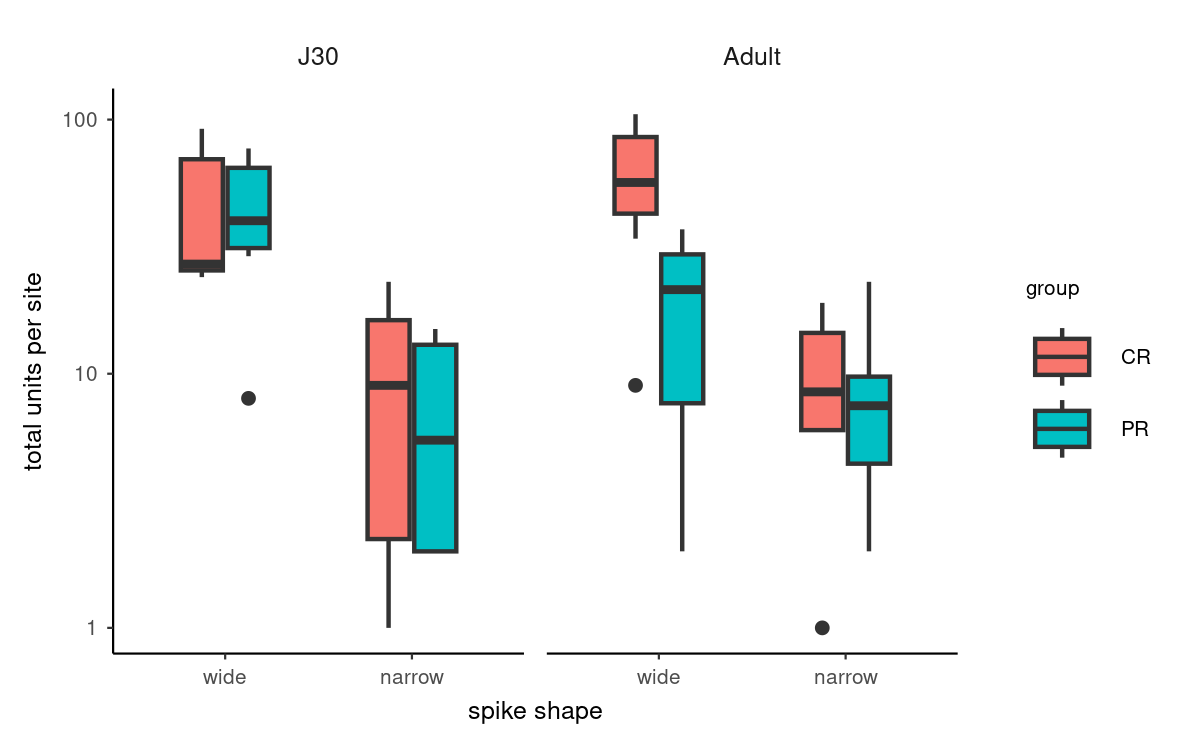

In [29]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p3.1 <- (
    site_summary
    |> ggplot(aes(spike, n_units, fill=group))
    + facet_wrap(~ age_group)
    + geom_boxplot(width=0.5, outlier.size=1)
    + scale_y_log10(name="total units per site")
    + scale_x_discrete(name="spike shape")
)
p3.1 + theme_classic() + my.theme

In [30]:
# GLMM
fm_units <- glmer(n_units ~ age_group*spike*group + (1 + spike|site), site_summary, control=glmerControl(optimizer="bobyqa"), family=poisson)
emmeans(fm_units, ~ group | age_group*spike) |> contrast("pairwise")

age_group = J30, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    0.0453 0.346 Inf   0.131  0.8961

age_group = Adult, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    1.1782 0.323 Inf   3.646  0.0003

age_group = J30, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    0.3030 0.411 Inf   0.737  0.4614

age_group = Adult, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    0.1223 0.373 Inf   0.328  0.7429

Results are given on the log (not the response) scale. 

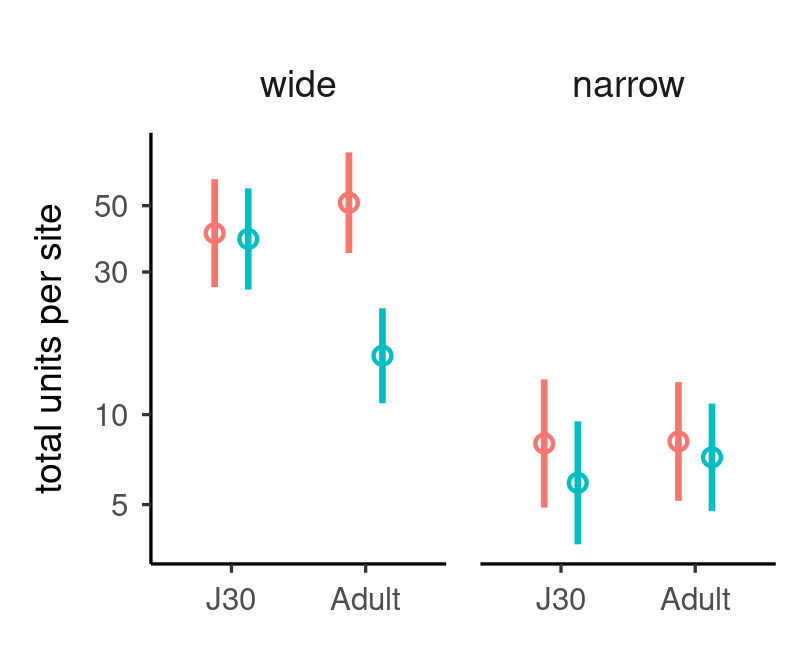

In [31]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_units
    |> emmeans(~ group*spike*age_group)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(age_group, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="total units per site")
    + theme_classic() + my.theme + no.legend
)
p 

In [32]:
pdf("../figures/total_units_per_age_group.pdf", width=1.8, height=1.45)
print(p)
dev.off()

ERROR: Error in pdf("../figures/total_units_per_age_group.pdf", width = 1.8, : cannot open file '../figures/total_units_per_age_group.pdf'


### Spontaneous firing rate

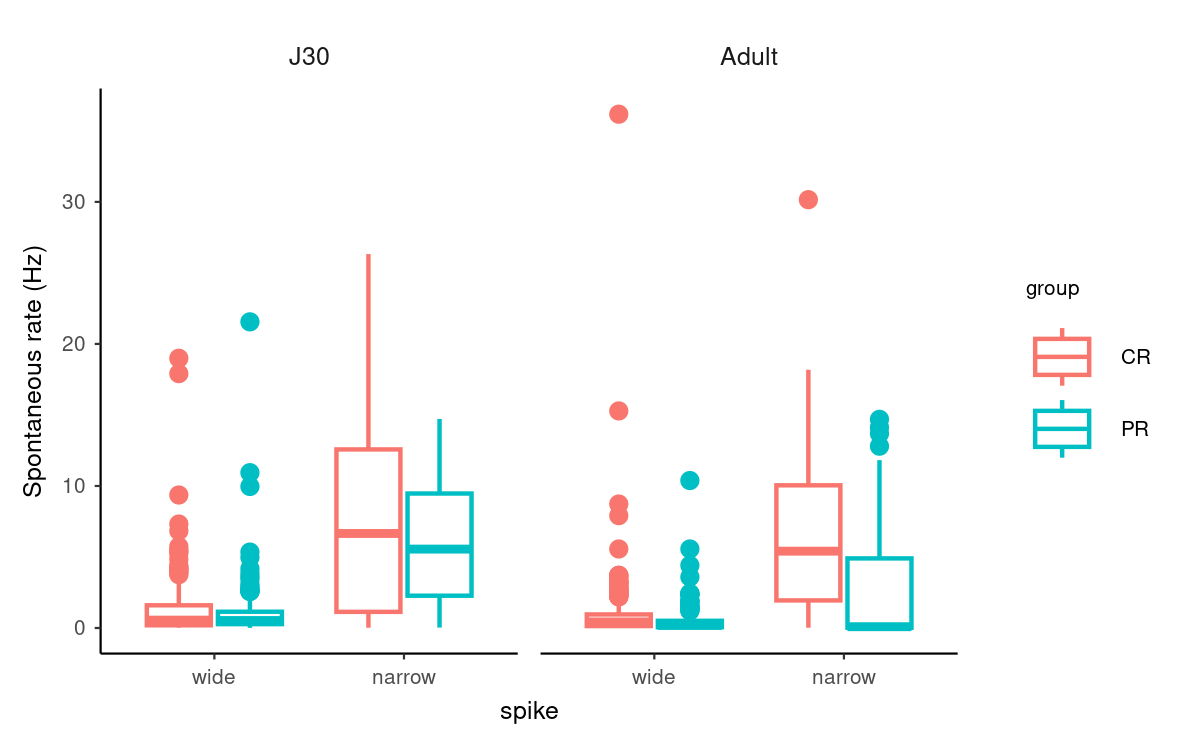

In [33]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_motif_summary
    |> filter(foreground=="silence")
    |> mutate(rate=mean(n_events / interval))
    |> ggplot(aes(spike, rate, color=group))
    + facet_wrap(~ age_group)
    + geom_boxplot()
    + scale_y_continuous(name="Spontaneous rate (Hz)")
)
p + theme_classic() + my.theme

In [34]:
fm_spont <- glmer(
    n_events ~ age_group*spike*group + (1|unit),
    offset=log(interval),
    family=poisson,
    control=glmerControl(optimizer = "bobyqa"),
    data=unit_motif_summary |> filter(foreground=="silence")
)

In [35]:
(
    fm_spont
    |> emmeans(~ group | age_group*spike)
    |> contrast("pairwise")
)

age_group = J30, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    0.0317 0.111 Inf   0.287  0.7743

age_group = Adult, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    0.7366 0.125 Inf   5.883  <.0001

age_group = J30, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    0.0433 0.255 Inf   0.170  0.8650

age_group = Adult, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    2.4919 0.228 Inf  10.938  <.0001

Results are given on the log (not the response) scale. 

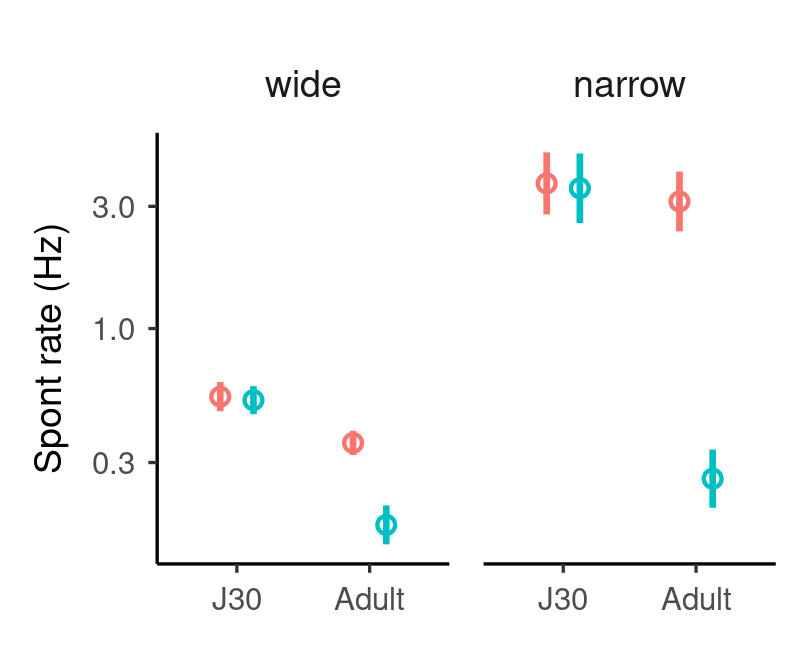

In [36]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_spont
    |> emmeans(~ group*spike*age_group, type="response", offset=0)
    |> confint(level=0.90)
    |> ggplot(aes(age_group, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="Spont rate (Hz)")
    + theme_classic() + my.theme + no.legend
)
p 

In [37]:
pdf("../figures/spont_rate_all_units.pdf", width=1.8, height=1.5)
print(p)
dev.off()

ERROR: Error in pdf("../figures/spont_rate_all_units.pdf", width = 1.8, height = 1.5): cannot open file '../figures/spont_rate_all_units.pdf'


### Evoked rate

`summarise()` has grouped output by 'group', 'age_group', 'spike'. You can
override using the `.groups` argument.


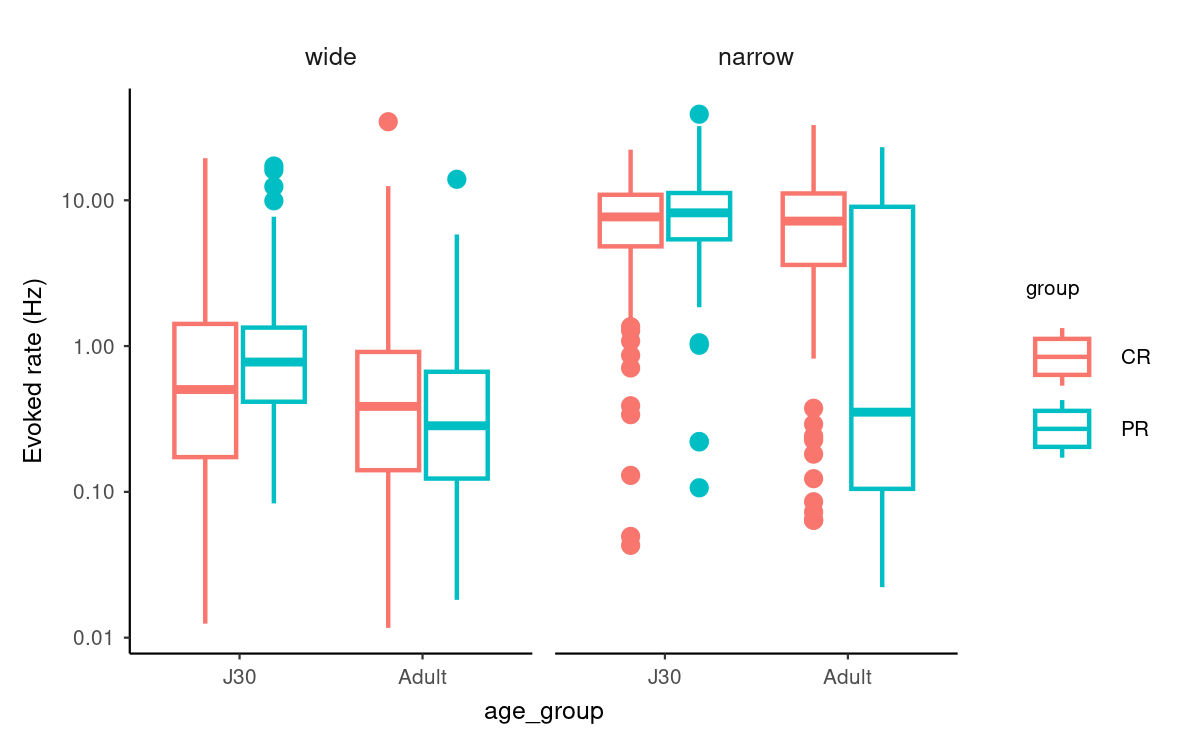

In [38]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_motif_summary
    |> filter(foreground!="silence")
    |> mutate(rate=mean(n_events / interval))
    |> group_by(group, age_group, spike, unit)
    |> summarize(rate=mean(rate))
    |> ggplot(aes(age_group, rate, color=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + scale_y_log10(name="Evoked rate (Hz)")
    + theme_classic() + my.theme
)
p 

In [39]:
fm_evoked <- glmer(
    n_events ~ group*age_group*spike + (1|unit),
    offset=log(interval),
    family=poisson,
    control=glmerControl(optimizer="bobyqa"),
    data=unit_motif_summary |> filter(foreground!="silence")
)

In [40]:
(
    fm_evoked
    |> emmeans(~ group | age_group*spike)
    |> contrast("pairwise")
)

age_group = J30, spike = wide:
 contrast estimate     SE  df z.ratio p.value
 CR - PR    -0.341 0.0974 Inf  -3.500  0.0005

age_group = Adult, spike = wide:
 contrast estimate     SE  df z.ratio p.value
 CR - PR     0.202 0.1093 Inf   1.848  0.0647

age_group = J30, spike = narrow:
 contrast estimate     SE  df z.ratio p.value
 CR - PR    -0.182 0.2253 Inf  -0.806  0.4202

age_group = Adult, spike = narrow:
 contrast estimate     SE  df z.ratio p.value
 CR - PR     1.654 0.1986 Inf   8.330  <.0001

Results are given on the log (not the response) scale. 

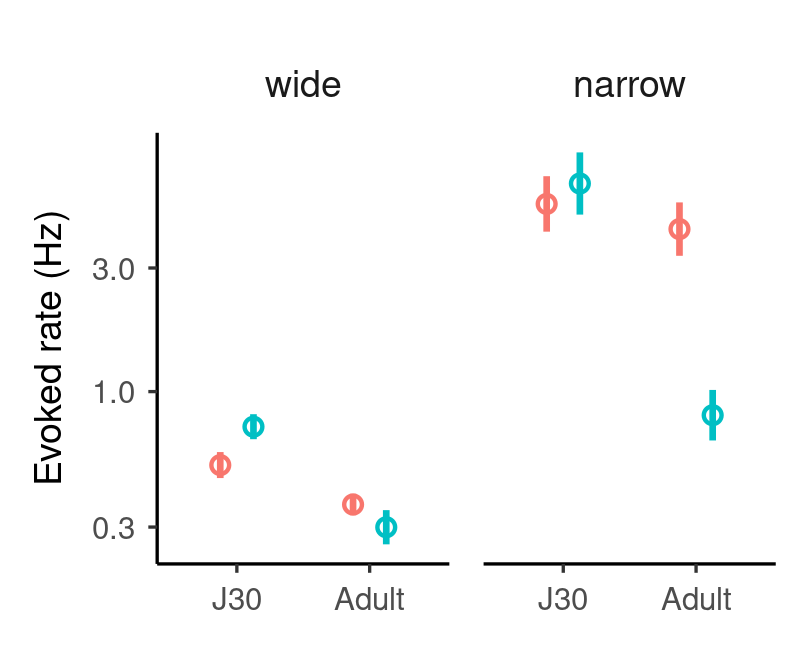

In [41]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_evoked
    |> emmeans(~ group*spike*age_group, type="response", offset=0)
    |> confint(level=0.90)
    |> ggplot(aes(age_group, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="Evoked rate (Hz)")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/evoked_rate_all_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Discriminability

Discriminability is what we use to decide whether neurons are auditory or not, so any trends need to be analyzed using all neurons.

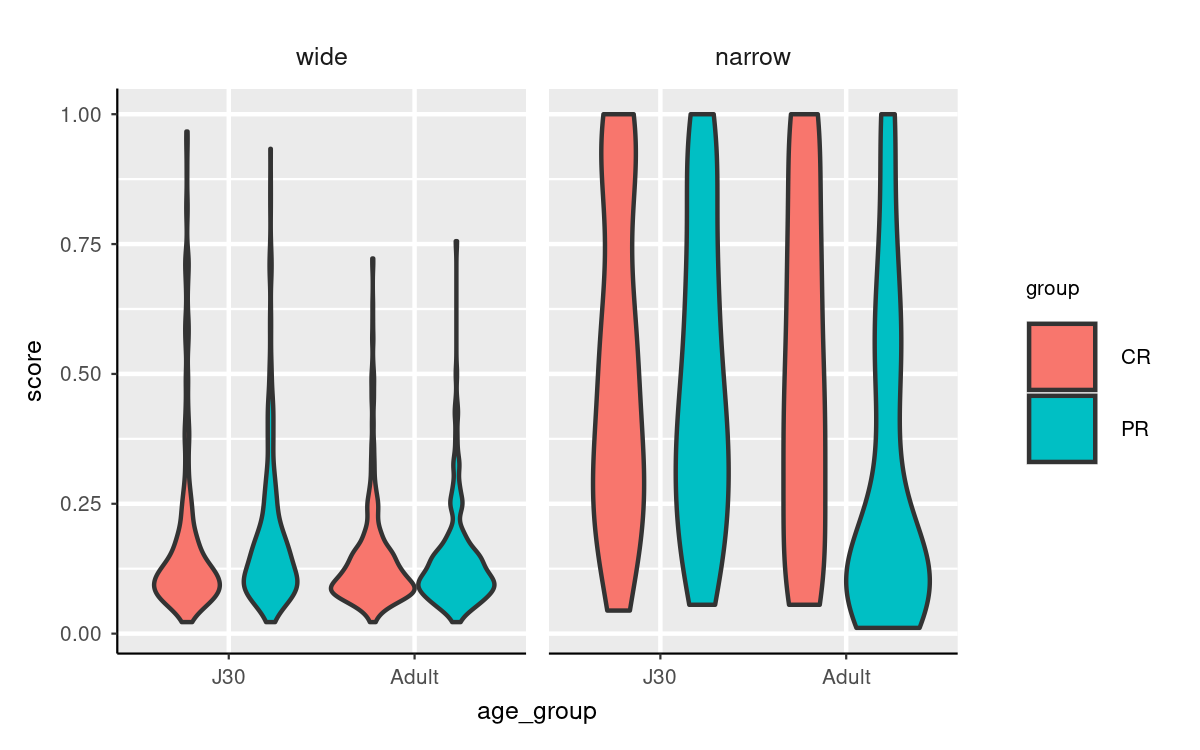

In [42]:
## raw classifier scores
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> ggplot(aes(age_group, score, fill=group))
    + facet_wrap(~ spike)
    + geom_violin()
    + my.theme
)
p 

In [43]:
## GLMM
## There are 90 comparisons for each trial, so score can be converted to a binomial RV by multiplying by 90
fm_discrim_score <- (
    unit_summary 
    |> mutate(n_correct=score * 90)
    |> glmer(cbind(n_correct, 90 - n_correct) ~ group*age_group*spike + (1|unit), 
             data=_, 
             control=glmerControl(optimizer="bobyqa"), 
             family=binomial)
)
emmeans(fm_discrim_score, ~ group | age_group*spike) |> contrast("pairwise")

age_group = J30, spike = wide:
 contrast estimate     SE  df z.ratio p.value
 CR - PR   -0.0425 0.0828 Inf  -0.513  0.6080

age_group = Adult, spike = wide:
 contrast estimate     SE  df z.ratio p.value
 CR - PR    0.0180 0.0930 Inf   0.194  0.8466

age_group = J30, spike = narrow:
 contrast estimate     SE  df z.ratio p.value
 CR - PR    0.1689 0.1902 Inf   0.888  0.3746

age_group = Adult, spike = narrow:
 contrast estimate     SE  df z.ratio p.value
 CR - PR    1.1224 0.1684 Inf   6.665  <.0001

Results are given on the log odds ratio (not the response) scale. 

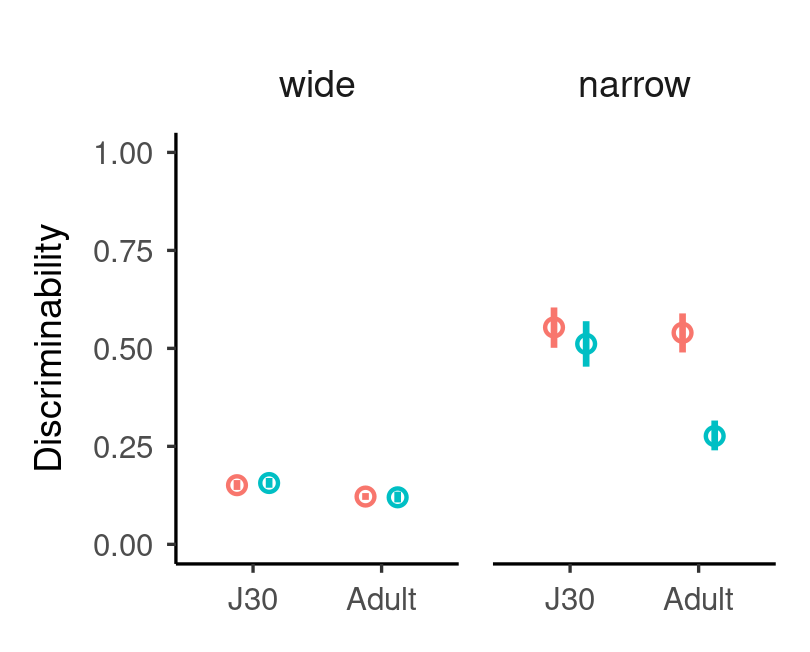

In [44]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_discrim_score
    |> emmeans(~ group*spike*age_group, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(age_group, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="Discriminability", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [45]:
pdf("../figures/discriminability_all_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

ERROR: Error in pdf("../figures/discriminability_all_units.pdf", width = 1.8, : cannot open file '../figures/discriminability_all_units.pdf'


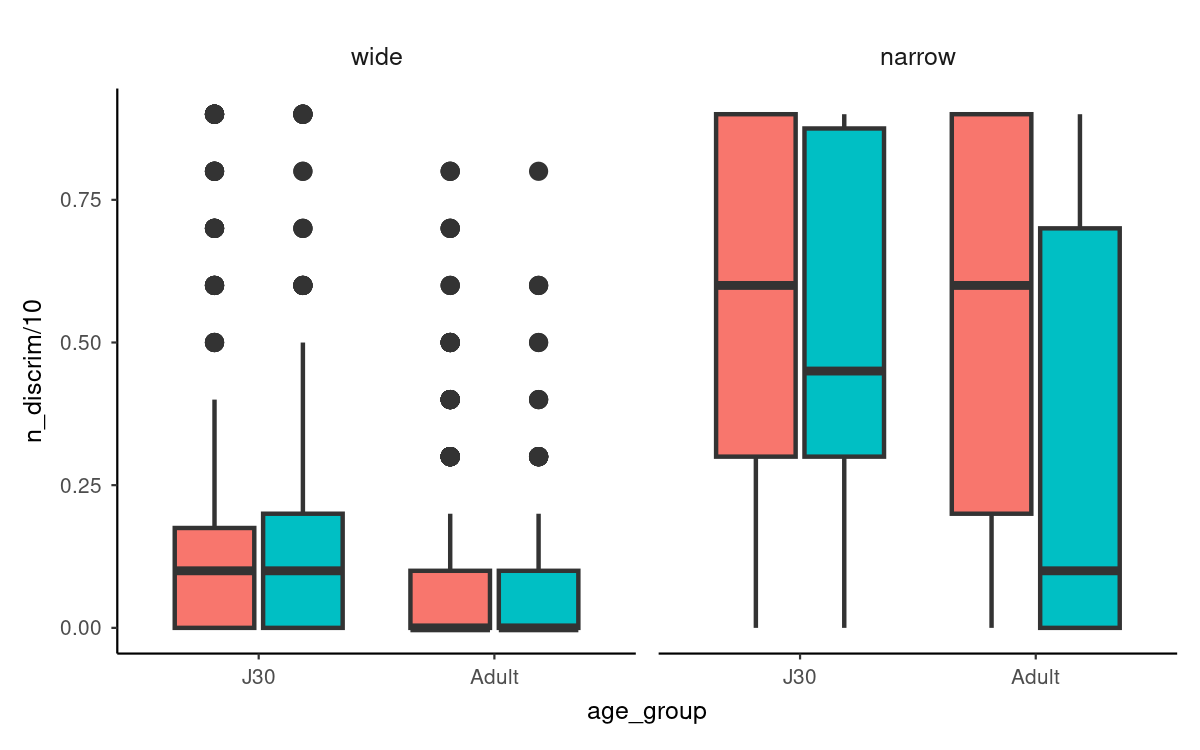

In [46]:
## number of discriminable motifs
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> ggplot(aes(age_group, n_discrim/10, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + theme_classic() + my.theme + no.legend
)
p + my.theme

In [47]:
## GLMM
## Alternatively, how many motifs are discriminable
fm_discrim_n <- (
    unit_summary
    |> glmer(cbind(n_discrim, 9 - n_discrim) ~ group*age_group*spike + (1|unit), data=_, control=glmerControl(optimizer="bobyqa"), family=binomial)
)
emmeans(fm_discrim_n, ~ group | age_group*spike) |> contrast("pairwise")

age_group = J30, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    -0.192 0.181 Inf  -1.060  0.2893

age_group = Adult, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     0.203 0.216 Inf   0.943  0.3456

age_group = J30, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     0.202 0.383 Inf   0.528  0.5974

age_group = Adult, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     1.804 0.347 Inf   5.201  <.0001

Results are given on the log odds ratio (not the response) scale. 

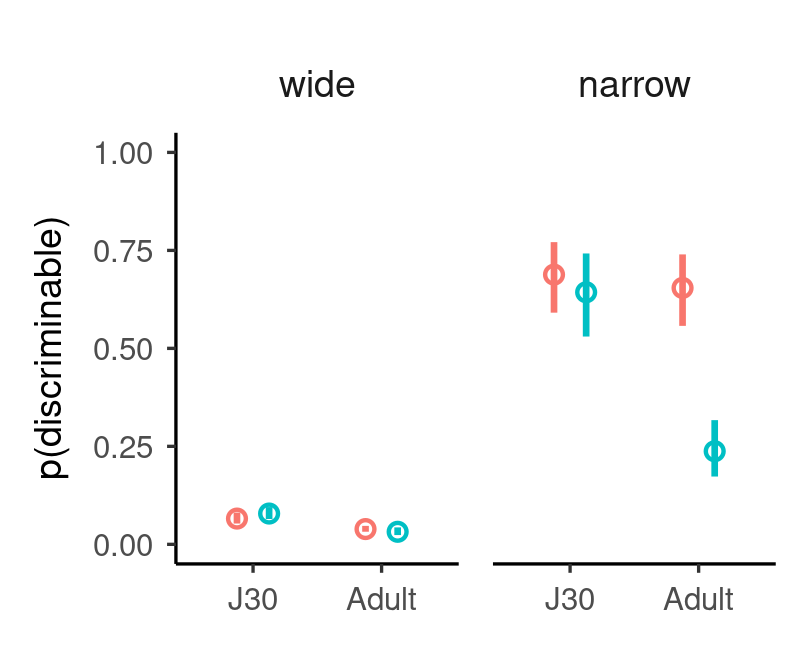

In [48]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_discrim_n
    |> emmeans(~ group*spike*age_group, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(age_group, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="p(discriminable)", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/p_discriminable_all_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Number of auditory units per site

Supplementary

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    site_summary
    |> ggplot(aes(area, n_auditory, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + my.theme
)

In [ ]:
(
    site_summary
    |> ggplot(aes(area, n_auditory_rate, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + my.theme
)

In [ ]:
# GLMM
fm_aud_units <- glmer(n_auditory ~ group*area*spike + (1 + spike|site), site_summary, control=glmerControl(optimizer="bobyqa"), family=poisson)
emmeans(fm_aud_units, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_aud_units
    |> emmeans(~ group*spike*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="auditory units per site")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/aud_units_per_site.pdf", width=1.8, height=1.45)
print(p)
dev.off()

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    site_summary
    |> ggplot(aes(area, n_auditory / n_units, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + scale_y_continuous(name="p(responsive)", limits=c(0, 1))
    + my.theme
)

In [ ]:
fm_aud_prop <- glmer(
    cbind(n_auditory, n_units - n_auditory) ~ group*area*spike + (1 + spike|site), 
    site_summary,
    control=glmerControl(optimizer="bobyqa"),
    family=binomial)
emmeans(fm_aud_prop, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_aud_prop
    |> emmeans(~ group*spike*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="p(auditory)", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p

In [ ]:
pdf("../figures/aud_units_proportion_site.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Selectivity (auditory units only)

A very simple definition of selectivity is related to what proportion of stimuli evoke a significant response.

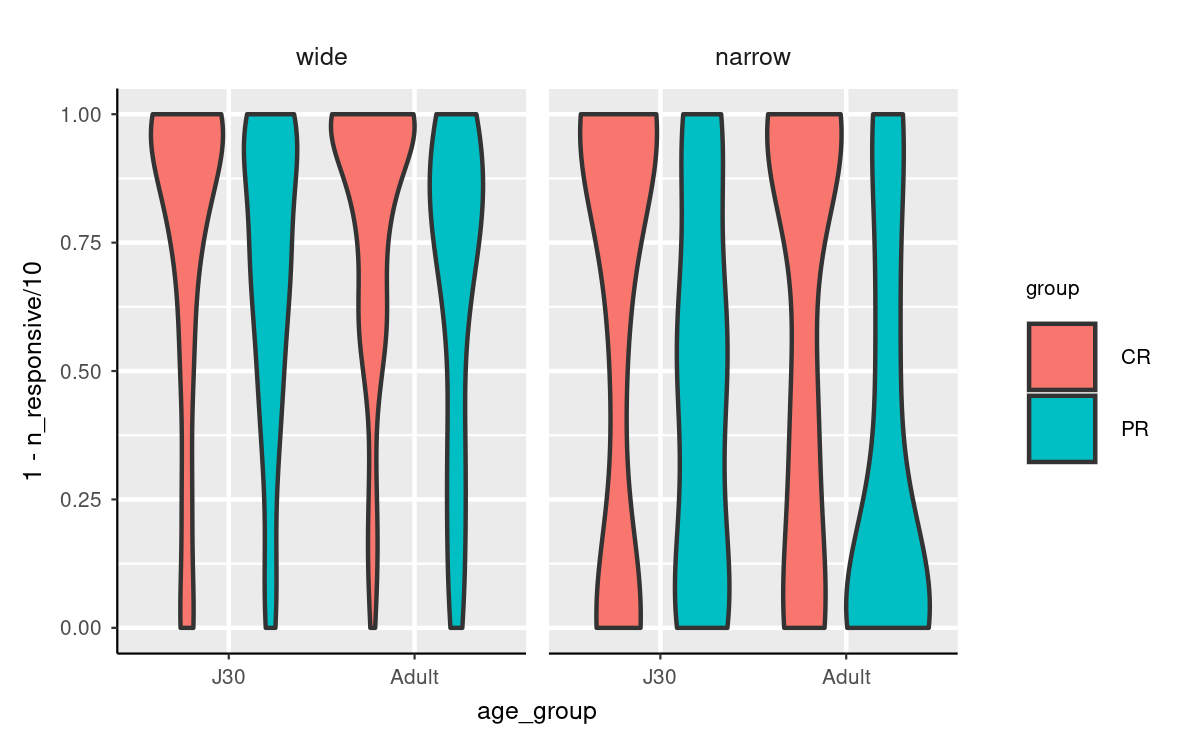

In [49]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> filter(is_auditory)
    |> ggplot(aes(age_group, 1 - n_responsive/10, fill=group))
    + facet_wrap(~ spike)
    + geom_violin()
)
p + my.theme

In [50]:
## GLMM
fm_selectivity <- (
    unit_summary 
    |> filter(is_auditory)
    |> glmer(
        cbind(10 - n_responsive, n_responsive) ~ group*age_group*spike + (1|unit), 
        data=_,
        control=glmerControl(optimizer="bobyqa"),
        family=binomial)
)
emmeans(fm_selectivity, ~ group | age_group*spike) |> contrast("pairwise")

age_group = J30, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     0.739 0.337 Inf   2.194  0.0282

age_group = Adult, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     1.359 0.416 Inf   3.268  0.0011

age_group = J30, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     1.330 0.538 Inf   2.474  0.0134

age_group = Adult, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     2.400 0.579 Inf   4.146  <.0001

Results are given on the log odds ratio (not the response) scale. 

In [53]:
print(0.028 > 0.05)

[1] FALSE


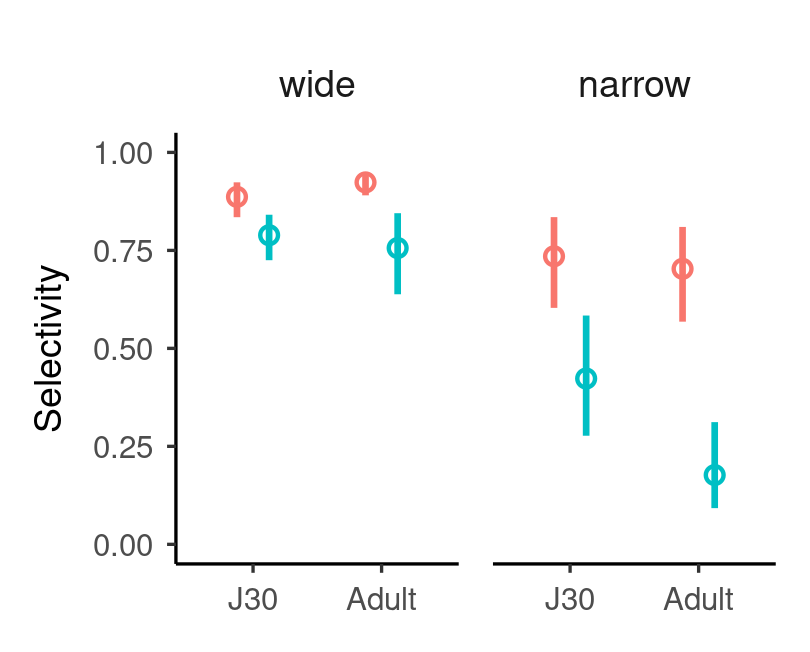

In [51]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_selectivity
    |> emmeans(~ group*spike*age_group, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(age_group, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="Selectivity", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/selectivity_auditory_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Selectivity - activity fraction

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> filter(is_auditory)
    |> ggplot(aes(area, activity_frac, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + my.theme
)
p

In [ ]:
## LMM
fm_selectivity <- lmer(
    activity_frac ~ group*area*spike + (1|site), 
    data=unit_summary |> filter(is_auditory))
emmeans(fm_selectivity, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=2.6, repr.plot.height=2.6, repr.plot.res = 450)
(
    unit_summary
    |> filter(is_auditory)
    |> ggplot(aes(score, 1 - n_discrim/10, color=group))
    + facet_grid(area ~ spike)
    + geom_point(alpha=0.4)
    #+ stat_smooth(method="lm", linewidth=0.5)
    + scale_x_continuous("Discriminability", limits=c(0,1))
    + scale_y_continuous("Selectivity", limits=c(0, 1))
    + theme_classic() + my.theme + no.legend
)

## Population sparseness

This is a quick and dirty way to look at sparseness, by calculating the proportion of units in a site that give significant responses to each motif.

In [ ]:
(
    unit_motif_responsive
    |> semi_join(filter(unit_discrim, is_auditory), by="unit")
    |> group_by(unit)
    |> arrange(desc(rate))
)

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
site_n_responsive <- (
    unit_motif_responsive
    # only auditory units?
    |> semi_join(filter(unit_discrim, is_auditory), by="unit")
    |> inner_join(select(unit_spike_features, unit, spike), by="unit")
    |> mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
    |> group_by(bird, group, area, spike, site, foreground)
    |> summarize(n_units=n(), n_responsive=sum(is_responsive))
)

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    site_n_responsive
    |> summarize(sparseness= 1 - mean(n_responsive) / mean(n_units))
    |> ggplot(aes(area, sparseness, fill=group))
    + facet_grid(~ spike)
    + geom_boxplot() # stat_summary(fun.data="mean_se")
    + theme_classic() + my.theme
)

In [ ]:
## GLMM
fm_sparseness <- glmer(
    cbind(n_units - n_responsive, n_responsive) ~ group*area*spike + (1 + area|bird),
    data=site_n_responsive,
    control=glmerControl(optimizer="bobyqa"),
    family=binomial)
emmeans(fm_sparseness, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_sparseness
    |> emmeans(~ group*spike*area, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="Sparseness", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/sparseness_auditory_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

In [ ]:
cr_wide <- (
    unit_motif_responsive
    |> inner_join(select(unit_spike_features, unit, spike), by="unit")
    |> mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
    |> filter(group=="PR") #, spike=="narrow", area=="L3/NCM")
)

In [ ]:
cr_wide_best_stim <- (
    cr_wide
    |> group_by(unit)
    |> summarize(best_stim=foreground[which.max(estimate)], max_resp=max(estimate), selectivity=1 - mean(is_responsive))
    |> arrange(best_stim, selectivity, max_resp)
    # |> filter(selectivity < 1)
    |> mutate(idx=row_number())    
)
cr_wide_best_stim

### Principal components

Another approach to measuring sparseness is to use principal components analysis to estimate the degree to which neural responses are correlated across stimulus conditions. The responses are organized into a conditions x neurons array. The principal components (row vectors) correspond to groups of neurons that covary. A sparse code should be characterized by a relatively flat eigenspectrum.

In [ ]:
(
    cr_wide
    |> inner_join(cr_wide_best_stim, by="unit")
    |> ggplot(aes(foreground, idx))
    + geom_tile(mapping=aes(fill=zscore))
    + scale_fill_gradient2()
    + theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_blank())
)

In [ ]:
options(repr.plot.width=3, repr.plot.height=3, repr.plot.res = 300)
pca <- (
    cr_wide
    |> pivot_wider(id_cols=unit, names_from=foreground, values_from=zscore)
    |> ungroup()
    |> select(-unit)
    |> as.matrix()
    |> t()
    |> prcomp()
)
plot(pca)

In [ ]:
options(repr.plot.width=3, repr.plot.height=3, repr.plot.res = 300)
pca <- (
    cr_wide
    |> pivot_wider(id_cols=unit, names_from=foreground, values_from=zscore)
    |> ungroup()
    |> select(-unit)
    |> as.matrix()
    |> t()
    |> prcomp()
)
plot(pca)

## Noise invariance

Just seeing if there is anything worth reporting in this paper.

In [ ]:
(
    unit_level_discrim
    |> inner_join(all_sites, by="site")
    |> ggplot(aes(background_dBFS, score))
    + facet_grid(spike ~ area)
    + stat_summary(aes(color=group))
    + geom_line(mapping=aes(color=group, group=unit), alpha=0.1)
    + theme_classic() + my.theme
)